In [13]:
%pip install -q pdfplumber PyPDF2 pypdfium2

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pdfplumber
import PyPDF2
import pypdfium2
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.stats import mode

# Function declaration

In [15]:
def get_header_footer_pos(image_array: np.ndarray, threshold: int = 127):
    """
    Crop header and footer from a grayscale image based on a pixel intensity threshold.

    Args:
        image_array (numpy.ndarray): Input image as a 2D array.
        threshold (int): Pixel intensity threshold to identify content.
    Returns:
        numpy.ndarray: Cropped image array.
    """
    height, _ = image_array.shape
    row_text_counts = np.sum(image_array < threshold, axis=1)
    has_text_signal = row_text_counts > 0
    
    # top crop (header)
    top_crop_row = 0
    reach_header = False
    for i in range(int(height * 0.15)):
        if has_text_signal[i]:
            reach_header = True
        if reach_header and not has_text_signal[i]:
            top_crop_row = i
            break
    
    # bottom crop (footer)
    bottom_crop_row = height
    reach_footer = False
    for i in range(height - 1, int(height * 0.85), -1):
        if has_text_signal[i]:
            reach_footer = True
        if reach_footer and not has_text_signal[i]:
            bottom_crop_row = i
            break
    
    return top_crop_row, bottom_crop_row

def detect_skew_angle(image_array, range_deg=3.0, step=0.2):
    """
    Detect skew angle of text in image using projection profile.
    """
    # Downscale for speed
    h, w = image_array.shape
    scale = 1000 / w
    if scale < 1:
        from scipy.ndimage import zoom
        # zoom is slow, simple slicing is faster
        # img_small = image_array[::int(1/scale), ::int(1/scale)]
        # Better: use PIL resize if available, but we have numpy array
        # Let's just slice
        step_size = int(1/scale)
        img_small = image_array[::step_size, ::step_size]
    else:
        img_small = image_array

    # Invert: text is white
    img_inv = 255 - img_small
    
    # Threshold to remove noise
    img_bin = img_inv > 128
    
    best_angle = 0
    max_variance = 0
    
    angles = np.arange(-range_deg, range_deg + step, step)
    
    for angle in angles:
        # Rotate
        # reshape=False to keep size, but might cut corners. 
        # Text lines are horizontal, so we want horizontal projection.
        rotated = rotate(img_bin, angle, reshape=False, order=0)
        
        # Horizontal projection (sum of rows)
        projection = np.sum(rotated, axis=1)
        
        # Variance of projection
        # High variance = sharp peaks (lines) and valleys (gaps)
        var = np.var(projection)
        
        if var > max_variance:
            max_variance = var
            best_angle = angle
            
    return best_angle

def extract_text_from_columns(page, x_tolerance=5, y_tolerance=5, page_id=None, skew_angle=0):
    """
    Extract text from a page, handling 2-column layouts by detecting a central vertical gap.
    Supports deskewing logic if skew_angle is provided.
    """
    # Get page dimensions
    x0_page, top_page, x1_page, bottom_page = page.bbox
    width = x1_page - x0_page
    
    words = page.extract_words()
    if not words:
        return ""
    
    # Convert angle to radians
    # Note: scipy.ndimage.rotate uses counter-clockwise as positive.
    # Coordinate rotation:
    # x' = x cos(theta) - y sin(theta)
    # y' = x sin(theta) + y cos(theta)
    # If image was rotated by `skew_angle` to be straight, it means the text is tilted by `skew_angle`.
    # To straighten it, we rotate coordinates by `-skew_angle`.
    theta = np.radians(-skew_angle)
    c, s = np.cos(theta), np.sin(theta)
    
    # Calculate rotated x-coordinates for all words
    # We use the center of the word
    word_centers = []
    for w in words:
        wx = (w['x0'] + w['x1']) / 2 - x0_page
        wy = (w['top'] + w['bottom']) / 2 - top_page # Relative to crop top
        
        # Rotate
        wx_rot = wx * c - wy * s
        word_centers.append(wx_rot)
        
    # Create histogram of rotated x-coordinates
    # We map the rotated x range to bins
    if not word_centers:
        return page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)
        
    min_x = min(word_centers)
    max_x = max(word_centers)
    
    # If range is too small, it's probably empty or single column
    if max_x - min_x < 10:
         return page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)

    # Binning
    bins = np.linspace(min_x, max_x, num=int(width/2)) # 2pt resolution
    hist, bin_edges = np.histogram(word_centers, bins=bins)
    
    # Smooth histogram slightly
    hist_smooth = np.convolve(hist, np.ones(3)/3, mode='same')
    
    # Look for gap in the middle 40%
    mid_idx_start = int(len(hist) * 0.3)
    mid_idx_end = int(len(hist) * 0.7)
    
    middle_hist = hist_smooth[mid_idx_start:mid_idx_end]
    
    # Find lowest density region (gap)
    # We look for a run of low values
    threshold = np.mean(hist) * 0.2 # Arbitrary low threshold
    
    is_gap = middle_hist < threshold
    
    # Find longest run of True in is_gap
    # ... (similar to previous logic but on histogram)
    
    # Simplified: just find the minimum in the smoothed histogram
    if len(middle_hist) == 0:
         return page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)

    min_val = np.min(middle_hist)
    min_indices = np.where(middle_hist == min_val)[0]
    best_idx = min_indices[len(min_indices)//2] + mid_idx_start
    
    split_x_rot = (bin_edges[best_idx] + bin_edges[best_idx+1]) / 2
    
    if page_id and abs(skew_angle) > 0.5:
        print(f"  [Page {page_id}] Skew: {skew_angle:.2f} deg. Split at rot_x={split_x_rot:.1f}")
    elif page_id:
        print(f"  [Page {page_id}] Split at x={split_x_rot:.1f}")

    # Define filter function
    # x_rot = x*c - y*s
    # We want x*c - y*s < split_x_rot
    # Note: x and y in filter are absolute page coordinates
    # Our split_x_rot is relative to crop top-left and rotated
    
    # Adjust split_val to absolute coordinates
    # x_rel = x_abs - x0_page
    # y_rel = y_abs - top_page
    # x_rot = (x_abs - x0_page)*c - (y_abs - top_page)*s
    #       = x_abs*c - y_abs*s - x0_page*c + top_page*s
    # So: x_abs*c - y_abs*s < split_x_rot + x0_page*c - top_page*s
    
    limit = split_x_rot + x0_page * c - top_page * s
    
    def is_left(obj):
        # Use center of object
        ox = (obj['x0'] + obj['x1']) / 2
        oy = (obj['top'] + obj['bottom']) / 2
        val = ox * c - oy * s
        return val < limit

    try:
        left_page = page.filter(is_left)
        right_page = page.filter(lambda o: not is_left(o))
        
        text_left = left_page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance) or ""
        text_right = right_page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance) or ""
        
        return text_left + "\n" + text_right
    except Exception as e:
        print(f"Error splitting columns: {e}")
        return page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)

# Crop Image

# OCR

Range: page **6 - 256**

In [16]:
page_range = list(range(6, 256))
results = []

### Run

In [17]:
# path declarations
input_pdf = "../data/raw/Duoc-Dien-Viet-Nam-V-tap-2.pdf"
output_csv = "../data/raw/raw_text_extract_2.csv"
output_txt = "../data/raw/raw_texts_2.txt"

In [18]:
with pdfplumber.open(input_pdf) as pdf_document:
    results = []
    
    # Pages with 2-column layout
    two_column_pages = set(range(13, 83)) | set(range(85, 257))

    for page_id in page_range:
        page = pdf_document.pages[page_id-1]
        
        # Render at high DPI for better header/footer detection
        dpi = 400
        p_image = page.to_image(resolution=dpi)
        image = p_image.original
        pix_width, pix_height = image.size
        image_array = np.array(image.convert("L"))  # Convert to grayscale
        
        # Detect skew
        skew_angle = detect_skew_angle(image_array)
        
        # Get crop positions in pixel coordinates
        top_crop_px, bottom_crop_px = get_header_footer_pos(image_array)
        
        # Get page dimensions from bbox
        p_x0, p_top, p_x1, p_bottom = page.bbox
        
        # Convert pixel coordinates to PDF points
        points_per_pixel = page.height / pix_height
        
        # Calculate absolute crop coordinates relative to page top
        top_crop_pt = p_top + (top_crop_px * points_per_pixel)
        bottom_crop_pt = p_top + (bottom_crop_px * points_per_pixel)
        
        # Ensure crop box is within page bounds
        top_crop_pt = max(p_top, min(top_crop_pt, p_bottom))
        bottom_crop_pt = max(p_top, min(bottom_crop_pt, p_bottom))
        
        # Extraction settings
        x_tolerance = 5
        y_tolerance = 5
        
        # Determine if we should use column extraction
        use_column_extraction = page_id in two_column_pages
        
        # Ensure top < bottom
        if top_crop_pt >= bottom_crop_pt:
            print(f"Warning: Invalid crop on page {page_id}, skipping crop")
            if use_column_extraction:
                text = extract_text_from_columns(page, x_tolerance=x_tolerance, y_tolerance=y_tolerance, page_id=page_id, skew_angle=skew_angle)
            else:
                text = page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)
        else:
            # Create crop bounding box (x0, top, x1, bottom)
            bbox = (p_x0, top_crop_pt, p_x1, bottom_crop_pt)
            
            # Apply crop and extract text
            cropped_page = page.crop(bbox)
            if use_column_extraction:
                text = extract_text_from_columns(cropped_page, x_tolerance=x_tolerance, y_tolerance=y_tolerance, page_id=page_id, skew_angle=skew_angle)
            else:
                text = cropped_page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)
        
        if text:
            results.append((page_id, text.strip()))
        else:
            print("No text detected on page", page_id)
            results.append((page_id, ""))

  [Page 13] Split at x=293.1
  [Page 14] Split at x=299.9
  [Page 15] Split at x=300.4
  [Page 16] Split at x=301.3
  [Page 17] Split at x=293.2
  [Page 18] Split at x=300.4
  [Page 19] Split at x=302.2
  [Page 20] Split at x=302.9
  [Page 21] Split at x=301.8
  [Page 22] Split at x=294.8
  [Page 23] Split at x=303.2
  [Page 24] Split at x=297.1
  [Page 25] Split at x=297.3
  [Page 26] Split at x=297.0
  [Page 27] Split at x=298.9
  [Page 28] Split at x=305.2
  [Page 29] Split at x=296.9
  [Page 30] Split at x=304.8
  [Page 31] Split at x=295.0
  [Page 32] Split at x=305.8
  [Page 33] Split at x=297.7
  [Page 34] Split at x=302.0
  [Page 35] Split at x=296.9
  [Page 36] Split at x=303.0
  [Page 37] Split at x=303.1
  [Page 38] Split at x=300.3
  [Page 39] Split at x=299.2
  [Page 40] Split at x=299.2
  [Page 41] Split at x=303.4
  [Page 42] Split at x=301.2
  [Page 43] Split at x=300.0
  [Page 44] Split at x=304.3
  [Page 45] Split at x=294.8
  [Page 46] Split at x=306.8
  [Page 47] Sp

### Process the result

In [19]:
df = pd.DataFrame(results, columns=["page_id", "text"])
df = df.sort_values(by='page_id').reset_index(drop=True)
df.to_csv(output_csv, index=False, encoding='utf-8')

In [20]:
df.head()

,page_id,text
0,6,Dược ĐIÊN VIỆT NAM V\nQUI ĐỊNH CHUNG\n1. Tên c...
1,7,Mát: 10 °c đến 20 °c.\nNhiệt độ phòng: 20 °c đ...
2,8,DƯỢC ĐIÊN VIỆT NAM V\n17. Trong chuyên luận kh...
3,9,DƯỢC ĐIỀN VIỆT NAM V\n27. Hỗn hợp của các chất...
4,10,39. Dược liệu dùng sàn xuất thuốc thành phẩm (...


## EDA

count     250.000000
mean     4317.008000
std       627.647831
min        29.000000
25%      4107.750000
50%      4344.000000
75%      4625.750000
max      5640.000000
Name: text, dtype: float64


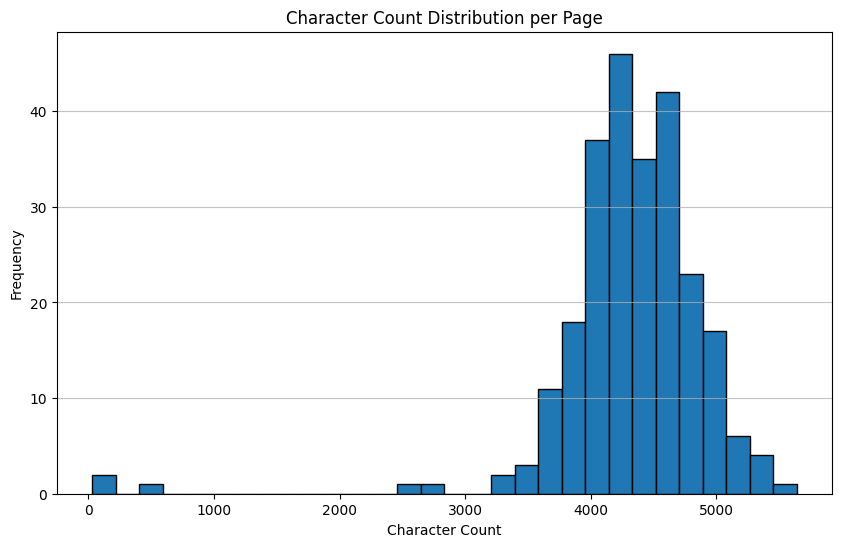

In [21]:
try:
    df.shape
except Exception:
    print("Loading data from CSV...")
    df = pd.read_csv(output_csv, encoding='utf-8')
    df.shape
    
character_count = df['text'].str.len()
print(character_count.describe())
plt.figure(figsize=(10, 6))
plt.hist(character_count, bins=30, edgecolor='black')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Count Distribution per Page')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [22]:

low_char_pages = df[character_count < 500]
print(f"Pages with character count < 500: {len(low_char_pages)}")
print("\nFirst 10 pages with character count < 500:")
print(low_char_pages.head(10))

Pages with character count < 500: 2

First 10 pages with character count < 500:
    page_id                                               text
6        12  Các chuyên luận\nHƯYÉT THANH, SINH PHẨM\nVÀ VẮ...
78       84                    Các chuyên luận\nDươc LIÊU\n• •


In [23]:
import re
delimeters = r'.?!\n'

all_text = " ".join(df['text'].tolist())

sentences = re.split(f'[{delimeters}]', all_text)
sentences = [s.strip() for s in sentences if s.strip() and len(s.strip()) > 20]
sentence_count = len(sentences)
print(f"Total number of sentences: {sentence_count}")

print("First 10 sentences:")
for i, sentence in enumerate(sentences[:20]):
    print(f"{i+1}. {sentence}")

Total number of sentences: 20836
First 10 sentences:
1. Tên chính cùa các chuyên luận là tcn Việt Nam, sau tên Việt Nam là tên Latin và những tên Việt Nam thông dụng
2. Đối với dược liệu: Có thể dùng tên qui ước cùa dược liệu hoặc dùng tên cây, con kèm theo bộ phận dùng lảm thuốc đê
3. làm tên chuyên luận, những từ chỉ bộ phận dùng lảm thuốc để trong dấu ngoặc đơn, ví dụ: (Lá), (Quả), (Thân rễ)
4. qui ước của dược liệu là tên của vị thuốc đã được dùng trong y học cổ truyền, ví dụ: Phù bình, Bạch giới tử
5. Mỗi chuyên luận cùa Dược điển Việt Nam V (chuyên luận riêng hay phụ lục) là một tiêu chuẩn về chât lượng thuôc hoặc
6. phương pháp kiểm nghiệm thuốc của Việt Nam
7. Nguyên từ lượng các nguyên tố trong Dược điển Việt Nam V là các giá trị đã được thừa nhận ghi ữong Phụ lục
8. Bảng nguyên tử lượng các nguyên tổ
9. Các đơn vị đo lường dùng trong Dược điển Việt Nam V đều tuân theo Luật Đo lường ban hành ngày 11/11/2011 và
10. Nghị định của Chính phủ sổ 86/2012/NĐ-CP ngày 19/10/2012 quy đị

In [24]:
with open(output_txt, "w", encoding='utf-8') as f:
    f.write(all_text)
    print("Saved to", output_txt)

Saved to ../data/raw/raw_texts_2.txt
